# Summerschool: Social Data Science - Exam Project
## Project: The Trump Twitter Effect
### Group 17. Exam Numbers: 41, 96, 127, 220

*This project studies whether Donald Trump’s sentiment can be used to predict the stock market movements. We conduct a sentiment analysis of his tweets, and uses upervised machine learning to try to predict the Dow Jones stock movement based on his sentiment.*

We start by importing our data source to Python. The file `tweets.json` is created from [the Trump twitter archive](http://www.trumptwitterarchive.com/archive). We have selected all tweets since formal announcement of candidacy.

**DOCSTRING**

Below we provide our docstring to the data project. 
We import the relevant packages, some of which will require installation through either `pip install` or `conda install`. 

In [213]:
'''
DOCSTRING:
Last updated: August 30th 2019.

This project analyzes Donald J. Trump's twitter data and presents a visual analysis of key elements.
It makes use of several packages, some of which should be installed via either pip or conda.
Executing the code cells will save files to the relative path of this Jupyter Notebook. 

'''
## Importing packages
import pandas as pd
import scraping_class, time, json, codecs
import seaborn as sns
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from afinn import Afinn
from fredapi import Fred
from tqdm import tqdm
from math import sqrt
import statsmodels.api as sm
from matplotlib import pyplot
import requests
# Machine learning
import sklearn
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, validation_curve, TimeSeriesSplit, train_test_split
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
% matplotlib inline

**Sentiment analyzer**

We have to sentiment analyzers: AFINN and VADER. We define functions for both in the following.
Recall that AFINN ranks the sentence from -5 to 5 and VADER from -1 to 1. 

In [37]:
# Define sentiment analyzer score

# VADER
def sentiment_analyzer_scores(sentence):
    analyser = SentimentIntensityAnalyzer()
    score = analyser.polarity_scores(sentence)
    return score

# AFINN
def afinn_sentiment_analyzer_scores(sentence):
    afinn = Afinn(language='en')
    score = afinn.score(sentence)
    return score

sentence_1 = 'I do love ice cream'
sentence_2 = 'I do not love ice cream'
print('', sentence_1, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_1), '\n',                                                                   
sentence_1, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_1)['compound'], '\n',
sentence_2, 'has an AFINN sentiment of', afinn_sentiment_analyzer_scores(sentence_2), '\n',
sentence_2, 'has a VADER sentiment of', sentiment_analyzer_scores(sentence_2)['compound'])

 I do love ice cream has an AFINN sentiment of 3.0 
 I do love ice cream has a VADER sentiment of 0.6369 
 I do not love ice cream has an AFINN sentiment of 3.0 
 I do not love ice cream has a VADER sentiment of -0.5216


Based on the results, we see that AFINN is not able to account for the negation, we therefore our analysis continue using only VADER.

### Collecting data

**Trump's tweets**

We set up our connector to the relevant data source and log our connections in a file called *my_log*. 
We later use the log file to visualize our data connection attempts. Next, we scrape the **Trump Twitter Archive** for all tweets from the *@realdonaldtrump* Twitter account.

In [38]:
logfile = 'my_log'## name your log file.
connector = scraping_class.Connector(logfile)
data = []

# Fetching data
for i in range(2015,2020):
    url = 'http://www.trumptwitterarchive.com/data/realdonaldtrump/'+str(i)+'.json'
    r, call_id = connector.get(url, 'Tweets')
    json_file = r.json() 
    data += json_file[::-1] # invert list
    time.sleep(0.5) # set sleep timer to prevent unintentional DOS attacks

**Bloomberg filtered tweets**

Next, we try to collect President Donald Trump's tweets that are relevant to the economy. Bloomberg has already collected these tweets [here](https://www.bloomberg.com/features/trump-tweets-market/).
When trying to fetch the `json` data, we are blocked by Bloomberg. We therefore reside to manually downloading the json text from the `url` and save it into a file called `bloomberg.json`.

In [39]:
# Bloomberg filtered tweets
url = 'https://www.bloomberg.com/bbg-gfx/trump-market-tweets-vs-dow/main.json' # json format
r, call_id = connector.get(url, 'Bloomberg - Tweets')
# json_file = r.json() 
# df_bloom = pd.read_json(json_file)
r.text[:500]

'<!doctype html>\n<html>\n<head>\n    <title>Bloomberg - Are you a robot?</title>\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n    <link rel="stylesheet" type="text/css" href="https://assets.bwbx.io/font-service/css/BWHaasGrotesk-55Roman-Web,BWHaasGrotesk-75Bold-Web,BW%20Haas%20Text%20Mono%20A-55%20Roman/font-face.css">\n    <style rel="stylesheet" type="text/css">\n        html, body, div, span, applet, object, iframe,\n        h1, h2, h3, h4, h5, h6, p, blockquote, pre,\n  '

In [40]:
# load the json file using utf-8 encoding
data_bloom = json.load(codecs.open('bloomberg.json', 'r', 'utf-8-sig'))

**Alpha vantage**

Collecting stock data from the Dow Jones Industrial Average index and S&P 500 using the **Alpha vantage API**.

In [41]:
# Converting the response to datetime
def convert_response(d):
    for dt, prec in d['Time Series (Daily)'].items():
        r = {'datetime':dt}
        r.update(prec)
        yield r

# Looping through DJI and S&P500
indices = {'^DJI':'dji_data_collection','SPX':'sp_data_collection'}
counter = 0
for i,j in indices.items():
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+i+"&outputsize=full&apikey="
    apikey = "Z6OIONR9OK9RAHMX"
    r, call_id = connector.get(url+apikey, j) #ask for help regarding connector
    if counter == 0:
        data_dji = r.json()
    else:
        data_sp =  r.json()
    counter += 1
    time.sleep(0.5)

Defining the function:

In [436]:
# Connecting to the Alpha Vantage API and fetching data
def AlphaVantage(data):
    df = pd.DataFrame(convert_response(data))
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime',inplace=True)
    df.sort_index(inplace=True)

    #change the name
    df = df.rename(columns={ '1. open':'open','2. high':'high','3. low':'Low','4. close':'close','5. adjusted close':'adj_close','6. volume':'volume','7. dividend amount':'Dividend amount','8. split coefficient':'Split coefficient'})

    df_data = df.iloc[:,[0,3,4,5]] #Select only the columns we want


    df_data['pct_change'] = '' #create empty column to contain pct. change
    r = df_data['adj_close'].astype(float).pct_change(1) #calculate the change
    df_data['pct_change'] = r #store the results in the empty column. There should be one row without a value
    # but fortunately that row is outside of our selected window

    df_data['bool'] = ''

    def pct_bool(df):
        df_pct_bool = []

        for x in df['pct_change']:
            if x > 0:
                df_pct_bool.append(1)
            else:
                df_pct_bool.append(0)

        df["bool"] = df_pct_bool

    pct_bool(df_data)

    df_data_final = df_data.copy()
    

    start_date = '2015-01-01'
    end_date = '2019-08-27'
    df_data_final = df_data[start_date:end_date]
    
    for i in df_data_final.columns:
        df_data_final[i] = df_data_final[i].astype(float)
    
    #df_dji_final.to_csv(data+'.csv') # Save file to CSV
    return df_data_final

### Data frames

Based on the scraped tweets, we set up our initial data frame. We convert the `datetime` to a readable format including timestamp and index by date. We also remove retweets from our data frame.

**Trump Twitter Archive**

In [43]:
### Creating and manipulating dataframes
# Main dataframe
df = pd.DataFrame(data)
date = [i[2]+i[1]+i[-1]+'-'+i[3] for i in df['created_at'].str.split(' ')] # slice date
df['datetime'] = date
df['datetime'] = pd.to_datetime(df['datetime'], format='%d%b%Y-%H:%M:%S') # format datetime 
#df = df[(df['datetime'] > '2017-01-20')] # filter by relevant date
df = df.query("is_retweet == False") # drop retweets
df = df.reset_index(drop=True).sort_values(by=['datetime']) # set index to date
df.index = df['datetime']
display(df.head())
print('Since', df.index[0], 'Mr. Trump has made', len(df), 'tweets') # print number of tweets

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime
datetime,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47


Since 2015-01-01 00:00:26 Mr. Trump has made 19650 tweets


**Trump tweets - Bloomberg**

In [44]:
# Tweets related to the economy
df_bloom = pd.DataFrame(data_bloom) # load data frame
df_bloom = df_bloom.sort_values(by='timestamp') # chronological order since inception
df_bloom['firstdifference'] = df_bloom['dow'] - df_bloom['dow'].shift() # first DJIA change since last row
df_bloom['relativechange'] = (df_bloom['dow'] - df_bloom['dow'].shift())/df_bloom['dow']*100 # relative change
df_bloom['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df_bloom['text']] # sentiment (VADER)
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']
display(df_bloom.head())

,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime
datetime,,,,,,,,,
2017-01-20 17:54:36,19827.2500,822502601304526848,822502601304526800,We will bring back our jobs. We will bring bac...,2017-01-20T17:54:36.000Z,NaN,NaN,0.7345,2017-01-20 17:54:36
2017-01-23 11:38:16,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,2017-01-23 11:38:16
2017-01-24 11:11:47,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,2017-01-24 11:11:47
2017-01-26 13:55:03,20100.9102,824616644370714627,824616644370714600,of jobs and companies lost. If Mexico is unwil...,2017-01-26T13:55:03.000Z,188.1993,0.936273,-0.5994,2017-01-26 13:55:03
2017-01-30 14:23:49,19971.1309,826073437735100418,826073437735100400,Where was all the outrage from Democrats and t...,2017-01-30T14:23:49.000Z,-129.7793,-0.649835,-0.1531,2017-01-30 14:23:49


**Sentiment analyzer**

Next, we run the sentiment analyzers on our data frame. As there are a lot of tweets this process is quite time consuming.

In [45]:
# Add sentiment to dataframe
df['sentiment'] = [sentiment_analyzer_scores(tweet)['compound'] for tweet in df['text']]
display(df.head())

,created_at,favorite_count,id_str,in_reply_to_user_id_str,is_retweet,retweet_count,source,text,datetime,sentiment
datetime,,,,,,,,,,
2015-01-01 00:00:26,Thu Jan 01 00:00:26 +0000 2015,33,550441381253382144,None,False,12,Twitter for Android,"""@JaayZen: @realDonaldTrump Thanks Donald. Now...",2015-01-01 00:00:26,0.7494
2015-01-01 00:02:37,Thu Jan 01 00:02:37 +0000 2015,28,550441927964106753,None,False,9,Twitter for Android,"""@teamconquerca: First time in the""Trump Inter...",2015-01-01 00:02:37,0.8711
2015-01-01 00:06:40,Thu Jan 01 00:06:40 +0000 2015,36,550442948375347200,None,False,15,Twitter for Android,"""@AngelaTN777: @gochico @realDonaldTrump: He S...",2015-01-01 00:06:40,0.4738
2015-01-01 00:09:01,Thu Jan 01 00:09:01 +0000 2015,18,550443540111962113,None,False,11,Twitter for Android,"""@JaayZen: @grandmiapens He has all the ingred...",2015-01-01 00:09:01,0.0000
2015-01-01 00:09:47,Thu Jan 01 00:09:47 +0000 2015,17,550443735054839808,None,False,7,Twitter for Android,"""@MarcAardvark: @realDonaldTrump @ronmeier123 ...",2015-01-01 00:09:47,0.6369


**Wordcloud**

Using the `wordcloud` package for Python we visualize the most frequently used words, both for all his collective tweets and tweets related to the economy.

In [46]:
# Define functions to display multiple tables
def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

#multi_table(dfs[0:4])  # display example

In [47]:
#WORDCLOUD

# function to get custom color for wordcloud
def custom_color(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = 30 # int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(100, 160)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)
 
# picture used as shape
trump_mask = np.array(Image.open("trump_mask.jpg")) # read image
trump_mask_T = np.array(Image.open("trump_mask.jpg").transpose(Image.FLIP_LEFT_RIGHT)) # read image transposed

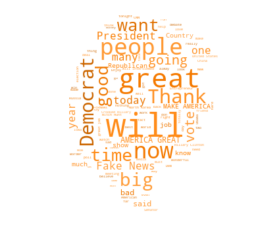

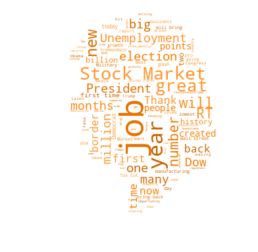

In [48]:
# wordcloud for ALL TWEETS
text = " ".join(tweet for tweet in df['text'][df['text'].str.contains(r'^(?:(?!https|co|amp|realDonaldTrump|Trump).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_all.png") # save file

# wordcloud for BLOOMBERG tweets

text = " ".join(tweet for tweet in df_bloom['text'][df_bloom['text'].str.contains(r'^(?:(?!https|co|amp).)*$')])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white",mask=trump_mask_T, 
                      contour_color ='black',color_func=custom_color).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud_bloom.png") # save file

In [49]:
print(df_bloom['sentiment'].describe())

count    383.000000
mean       0.320669
std        0.541008
min       -0.973500
25%        0.000000
50%        0.519800
75%        0.789650
max        0.978800
Name: sentiment, dtype: float64


Filtering the bloomberg data and plotting

In [462]:
df_bloom['outlier'] = abs(df_bloom['firstdifference']) >= df_bloom['firstdifference'].std()*3.5 # get outliers 3.5 times standard deviation

df_bloom_outlier = df_bloom.query('outlier == True')

print('The standard deviation is', round(df_bloom['firstdifference'].std(),2), '\nNumber of observations:',len(df_bloom),'\nOutliers are posted here:')
display(df_bloom_outlier) # display outliers
df_bloom_clean = df_bloom.query('outlier == False') # remove outliers 
print('AFTER OUTLIERS: The standard deviation is', round(df_bloom_clean['firstdifference'].std(),2), '\nAFTER OUTLIERS: Number of observations:',len(df_bloom_clean))

The standard deviation is 277.09 
Number of observations: 383 
Outliers are posted here:


,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,datetime,outlier
datetime,,,,,,,,,,
2018-08-22 20:07:29,25733.5996,1032358618576900096,1032358618576900100,Longest bull run in the history of the stock m...,2018-08-22T20:07:29.000Z,1629.7187,6.333038,0.6360,2018-08-22 20:07:29,True
2018-10-16 13:08:24,25798.4199,1052184484941049857,1052184484941049900,“8X more new manufacturing jobs now than with ...,2018-10-16T13:08:24.000Z,-1124.6094,-4.359218,0.0000,2018-10-16 13:08:24,True
2018-11-26 20:20:59,24640.2402,1067151249668214793,1067151249668214800,"....starts today, election is on December 4th....",2018-11-26T20:20:59.000Z,-1072.1504,-4.351217,0.6239,2018-11-26 20:20:59,True
2018-12-24 15:55:22,21792.1992,1077231267559755776,1077231267559755800,The only problem our economy has is the Fed. T...,2018-12-24T15:55:22.000Z,-2025.2403,-9.293419,0.1007,2018-12-24 15:55:22,True
2018-12-28 12:49:26,23062.4004,1078634025412116480,1078634025412116500,.....close the Southern Border. Bring our car ...,2018-12-28T12:49:26.000Z,1270.2012,5.507671,-0.2062,2018-12-28 12:49:26,True


AFTER OUTLIERS: The standard deviation is 221.34 
AFTER OUTLIERS: Number of observations: 378


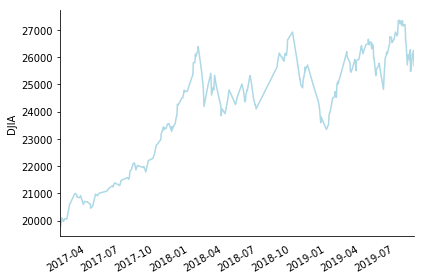

In [477]:
# Plotting figure
fig, ax = plt.subplots()

df_bloom_clean['dow'].plot(ax=ax, color='lightblue')

# Formatting
ax.set_ylabel('DJIA')
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('DJIA.png')

plt.show()

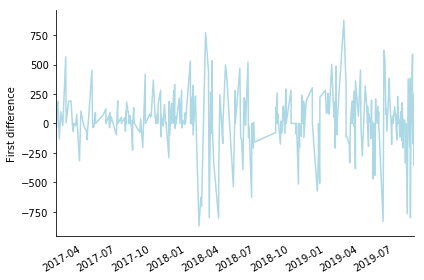

In [478]:
# Plotting figure
fig, ax = plt.subplots()

df_bloom_clean['firstdifference'].plot(ax=ax, color='lightblue')

# Formatting
ax.set_ylabel('First difference')
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels
plt.savefig('DJIAFD.png')

plt.show()

**Summary data for all tweets and bloomberg selected tweets TOTAL period**

In [455]:
column_id = ['count', 'mean', 'std', 'min', '25%', '50%', '75%' ,'max']
bloom_desc = list(round(df_bloom['sentiment'].describe(), 2))
All_desc = list(round(df['sentiment'].describe(),2))
tabledict = {'All tweets': All_desc, 'Selected tweets': bloom_desc}
tableX =  pd.DataFrame(tabledict, index = column_id).T
display(tableX)
display(tableX.to_latex(index=False))

,count,mean,std,min,25%,50%,75%,max
All tweets,19650.0,0.22,0.55,-0.99,-0.1,0.36,0.70,0.99
Selected tweets,383.0,0.32,0.54,-0.97,0.0,0.52,0.79,0.98


'\\begin{tabular}{rrrrrrrr}\n\\toprule\n   count &  mean &   std &   min &  25\\% &   50\\% &   75\\% &   max \\\\\n\\midrule\n 19650.0 &  0.22 &  0.55 & -0.99 & -0.1 &  0.36 &  0.70 &  0.99 \\\\\n   383.0 &  0.32 &  0.54 & -0.97 &  0.0 &  0.52 &  0.79 &  0.98 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [456]:
date = [i[0]+'-'+i[1][:8] for i in df_bloom['timestamp'].str.split('T')] # slice date
df_bloom['datetime'] = date
df_bloom['datetime'] = pd.to_datetime(df_bloom['datetime'], format='%Y-%m-%d-%H:%M:%S') # format datetime 
df_bloom['datetime']
df_bloom.index = df_bloom['datetime']

**Summary data for all tweets and bloomberg selected tweets by year**

In [55]:
df_bloom_Y = df_bloom['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_bloom_Y.describe(),2))
df_Y = df['sentiment'].groupby(pd.Grouper(freq='Y'))
display(round(df_Y.describe(),2))

,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2017-12-31,125.0,0.31,0.49,-0.97,0.00,0.42,0.73,0.94
2018-12-31,108.0,0.36,0.53,-0.90,0.00,0.54,0.81,0.98
2019-12-31,150.0,0.30,0.59,-0.97,-0.14,0.54,0.79,0.96


,count,mean,std,min,25%,50%,75%,max
datetime,,,,,,,,
2015-12-31,7536.0,0.26,0.48,-0.97,0.00,0.36,0.67,0.98
2016-12-31,4037.0,0.17,0.54,-0.96,-0.26,0.34,0.62,0.97
2017-12-31,2292.0,0.20,0.58,-0.97,-0.25,0.36,0.72,0.98
2018-12-31,3049.0,0.23,0.63,-0.99,-0.34,0.42,0.80,0.99
2019-12-31,2736.0,0.16,0.62,-0.98,-0.44,0.29,0.74,0.98


**Plotting monthly tweet count - Bloomberg**

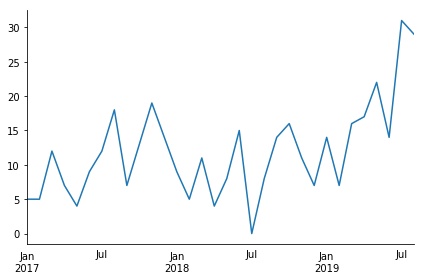

In [56]:
df_bloom['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('CounterSentiments.png')
plt.show()

**Plotting monthly tweet count - All tweets**

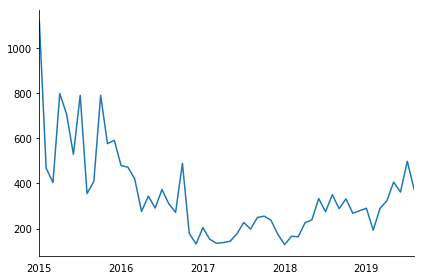

In [57]:

df['sentiment'].resample('M').count().plot() #secondary_y=True,label='Count',legend=True
ax = plt.gca()
ax.xaxis.label.set_visible(False) # remove axis label
ax.spines['right'].set_visible(False) # remove right spine
ax.spines['top'].set_visible(False) # remove top spine
ax.xaxis.set_ticks_position('none') # remove ticks from axis
plt.tight_layout() # prevents cutting off labels      
plt.savefig('AllTweets.png')
plt.show()

In [58]:
df_drop_datetime =df.drop("datetime", axis=1)

### Density plots

Density plot - all tweets

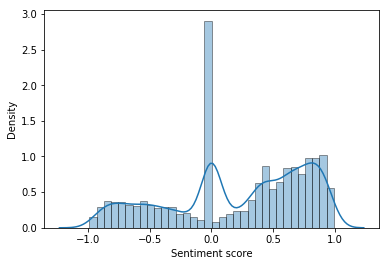

In [60]:
df_sentiment_mean_by_day = df_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(df_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})
    

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT.png')

Density plot - all tweets without 0.00 sentiment tweets

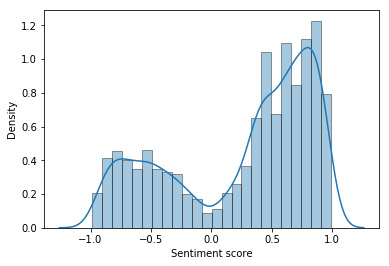

In [63]:
df_drop_null = df_drop_datetime.query('sentiment!=0')
df_null_sentiment_mean_by_day = df_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(df_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2.png')

In [64]:
df_bloom_drop_datetime =df_bloom.drop("datetime", axis=1)

Density plots - Bloomberg tweets

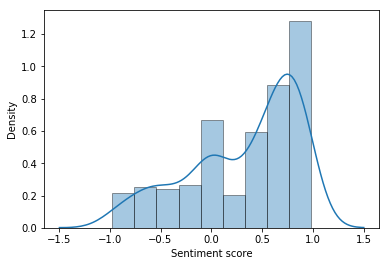

In [65]:
bloom_sentiment_mean_by_day = df_bloom_drop_datetime.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOTBLOOM.png')

Density plots - Bloomberg tweets without 0.00 sentiment tweets

By removing tweets with a sentiment score of zero, we have removed 3228 tweets
By removing tweets with a sentiment score of zero, we have removed 40 tweets


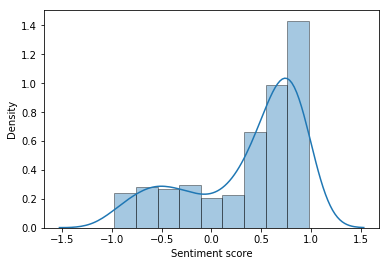

In [66]:
df_bloom_drop_null = df_bloom_drop_datetime.query('sentiment!=0')
bloom_null_sentiment_mean_by_day = df_bloom_drop_null.groupby('datetime')['sentiment'].mean()
Sentplot = sns.distplot(bloom_null_sentiment_mean_by_day, hist=True, kde=True,
             hist_kws={'edgecolor':'black'})

Sentplot.set_xlabel('Sentiment score')
Sentplot.set_ylabel('Density')
Sentplot.xaxis.label.set_fontsize(10)
Sentplot.yaxis.label.set_fontsize(10)
FigKDE = Sentplot.get_figure()
FigKDE.savefig('KDEPLOT2BLOOM.png')

print('By removing tweets with a sentiment score of zero, we have removed', df.shape[0]-df_drop_null.shape[0], 'tweets')
print('By removing tweets with a sentiment score of zero, we have removed', df_bloom.shape[0]-df_bloom_drop_null.shape[0], 'tweets')


### Machine Learning

Dataframe: Bloomberg

In [519]:
# Preparing bloomberg tweet data frame - DJIA
df_stock = AlphaVantage(data_dji)
df_bloom_clean = df_bloom.copy()
df_bloom_clean.reset_index(drop=True)
df_bloom_clean['time'] =  range(0,df_bloom_clean['datetime'].count())
df_bloom_clean['datetime'] = df_bloom_clean['datetime'].dt.date # format datetime
df_bloom_clean = df_bloom_clean.set_index('datetime',drop=True)
df_bloom_clean = df_bloom_clean.dropna()
df_merge = pd.merge(df_stock, df_bloom_clean, left_index=True, right_index=True)
features =  ['time','sentiment','volume','open']
display(df_merge.head(2))

C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\bjorn\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,open,close,adj_close,volume,pct_change,bool,dow,id,id_int,text,timestamp,firstdifference,relativechange,sentiment,outlier,time
datetime,,,,,,,,,,,,,,,,
2017-01-23,19794.7891,19799.8496,19799.8496,326690000.0,-0.001382,0.0,19799.8496,823495059010109440,823495059010109400,Busy week planned with a heavy focus on jobs a...,2017-01-23T11:38:16.000Z,-27.4004,-0.138387,0.4939,False,1
2017-01-24,19794.6797,19912.7109,19912.7109,374460000.0,0.005700,1.0,19912.7109,823850781946343427,823850781946343400,Will be meeting at 9:00 with top automobile ex...,2017-01-24T11:11:47.000Z,112.8613,0.566780,0.3382,False,2


Dataframe: All tweets

In [520]:
# # DATA ALL TWEETS - COMPARING TO S&P500
# df_all = df.copy()
# del df_stock
# df_stock = AlphaVantage(data_sp)
# for i in df_stock.columns:
#     df_stock[i] = df_stock[i].astype(float)
# df_all['datetime'] = df_all['datetime'].dt.date # format datetime
# df_all = df_all.set_index(df_all['datetime'],drop=True)
# df_merge = pd.merge(df_all, df_stock, left_index=True, right_index=True)
# df_merge['time'] =  range(0,df_merge['datetime'].count())
# features = ['time','sentiment','volume','open']
# display(df_merge[features].head())

**Time series split**

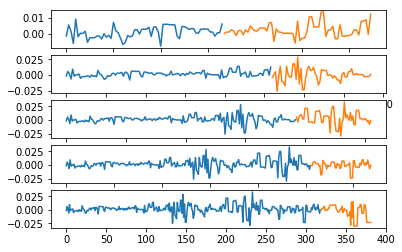

In [521]:
# X variables
X1 = df_merge[features].values # features
X = sm.add_constant(X1)
splits = TimeSeriesSplit(n_splits=5)

for train_index, test_index in splits.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
#pyplot.show()

# Y variable
Y = df_merge['pct_change'].values # target variable
splits = TimeSeriesSplit(n_splits=5) # number of splits
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
    y_train = Y[train_index]
    y_test = Y[test_index]
    #print('Observations: %d' % (len(y_train) + len(y_test)))
    #print('Training Observations: %d' % (len(y_train)))
    #print('Testing Observations: %d' % (len(y_test)))
    pyplot.subplot(510 + index)
    pyplot.plot(y_train)
    pyplot.plot([None for i in y_train] + [x for x in y_test])
    index += 1
pyplot.show()

**Linear Regression model**

In [522]:
linreg=linear_model.LinearRegression()
linreg.fit(X_train, y_train)
linreg.coef_
a=linreg.predict(X_test)

# Print RMSE
print('RMSE:',round(sqrt(np.mean((a-y_test)**2)),3))
# Print R^2
print('R-squared:',round(sklearn.metrics.r2_score(y_test, a)),3)

RMSE: 0.013
R-squared: -0.0 3


Conducting OLS regression and printing results

In [523]:
# Linear regression: Fitting model and printing results
Y = df_merge['pct_change'].values
ols = sm.OLS(Y, X)
ols_results = ols.fit()
res = ols_results.summary()
res.as_latex() # print to latex format
print(res)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     5.823
Date:                Wed, 28 Aug 2019   Prob (F-statistic):           0.000148
Time:                        17:06:36   Log-Likelihood:                 1253.2
No. Observations:                 382   AIC:                            -2496.
Df Residuals:                     377   BIC:                            -2477.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0180      0.011     -1.688      0.0

**CREATING PIPELINES**

In [524]:
pipe_preproc = make_pipeline(PolynomialFeatures(), StandardScaler())

# Fitting and transforming data 
pipe_preproc.fit(X_train)
X_train_prep = pipe_preproc.transform(X_train)
X_test_prep = pipe_preproc.transform(X_test)


**Pipeline for linear regression**

In [525]:
#PIPELINE LINEAR REGRESSION
pipe_lr = make_pipeline(PolynomialFeatures(include_bias=False), 
                        StandardScaler(),
                        LinearRegression()
                       )

pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

**Pipeline for LASSO**

In [553]:
#PIPELINE LASSO
lassolist = []
lambdas = np.logspace(-4, 4, 33) # Defining the lambda space wherein to test
# Testing different hyperparameter
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=1)
                              )
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_train)
    mse_lasso = mse(y_pred, y_train)
    lassolist.append(sqrt(mse_lasso))

# Selecting the optimal hyperparameter
hyperparam_lasso = pd.Series(lassolist,index=lambdas)
optimal_lasso = hyperparam_lasso.nsmallest(1)    

# Updating pipeline with optimal parameter
pipe_lasso = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=optimal_lasso.index[0]))
pipe_lasso.fit(X_train,y_train)

# Print optimal hyperparameter
print('Optimal hyperparameter (lambda) value for LASSO:', optimal_lasso)

C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Optimal hyperparameter (lambda) value for LASSO: 0.0001    0.46746
dtype: float64


In [547]:
# LASSO: Fitting the model and printing coefficients
LASSO = linear_model.Lasso(alpha=optimal_lasso.index[0])
LASSO.fit(X_train, y_train)
LASSO.coef_

array([-1.17350818e-04, -3.58027798e-02, -4.99030927e-10, -1.05344989e-05])

**Pipeline for Ridge**

In [555]:
#PIPELINE RIDGE
ridgelist = []
lambdas = np.logspace(-4, 4, 33) # Defining the lambda space wherein to test
# Testing different hyperparameter
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=1)
                              )
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_train)
    mse_ridge = mse(y_pred, y_train)
    ridgelist.append(sqrt(mse_ridge))

# Selecting the optimal hyperparameter
hyperparam_ridge = pd.Series(ridgelist,index=lambdas)
optimal_ridge = hyperparam_ridge.nsmallest(1)

# Updating pipeline with optimal parameter
pipe_ridge = make_pipeline(PolynomialFeatures(degree=3,include_bias=False), 
                               StandardScaler(),
                               Ridge(alpha=optimal_ridge.index[0]))
pipe_ridge.fit(X_train,y_train)

# Print optimal hyperparameter
print('Optimal hyperparameter (lambda) value for Ridge:', optimal_ridge)

Optimal hyperparameter (lambda) value for Ridge: 0.0001    0.455786
dtype: float64


In [556]:
# Ridge: Fitting the model and printing coefficients
ridge = linear_model.Ridge(alpha=optimal_ridge.index[0])
ridge.fit(X_train, y_train)
ridge.coef_

C:\Users\bjorn\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=3.95966e-17): result may not be accurate.
  overwrite_a=True).T


array([-1.17093647e-04, -3.61673655e-02, -4.98887875e-10, -1.05424430e-05])

**Print RMSE for each regularization**

In [557]:
# Printing the RMSE: root mean squared error
print('Linear Regression', round(sqrt(mse(pipe_lr.predict(X_test),y_test)), 3))
print('Ridge', round(sqrt(mse(pipe_ridge.predict(X_test),y_test)), 3))
print('Lasso', round(sqrt(mse(pipe_lasso.predict(X_test),y_test)), 3))
# Dictionary 
pipe_dict = {'pipe_lr':sqrt(mse(pipe_lr.predict(X_test),y_test))
            , 'pipe_ridge':sqrt(mse(pipe_ridge.predict(X_test),y_test))
            , 'pipe_lasso':sqrt(mse(pipe_lasso.predict(X_test),y_test))
            }
print('Smallest RMSE obtained using', min(pipe_dict, key=pipe_dict.get))

ValueError: X shape does not match training shape

Choosing LASSO as the preferred choice. Next, we construct the learning curve.

In [558]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_ridge,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(0.1, 1.0, 10),
                   scoring='neg_mean_squared_error',                 
                   cv=5)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head())

                Train          Test
sample size                        
27           0.017830  2.751549e+08
55           0.106927  3.441093e+03
83           0.119495  6.984433e+03
111          0.138541  5.248454e+03
139          0.153037  4.098242e+03


**Plotting the learning curve**

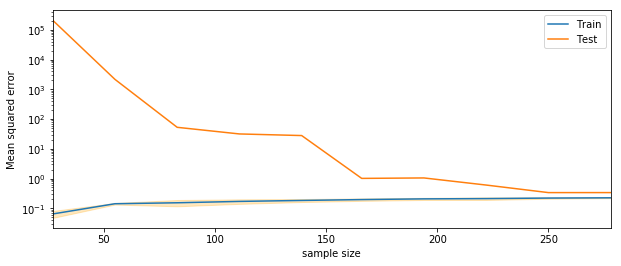

In [552]:
f_learn, ax = plt.subplots(figsize=(10,4))
mse_.plot(ax=ax, logy=True)

# Plotting 95% confidence band
ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, 
                color='orange')
ax.set_ylabel('Mean squared error')

f_learn.savefig("LearningCurve.png")

### Classification

Splitting while not disrupting the chronological order.

In [543]:
X = df_merge[features].values
splits = TimeSeriesSplit(n_splits=10)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    X_train = X[train_index]
    X_test = X[test_index]

Y = df_merge['bool'].values
splits = TimeSeriesSplit(n_splits=10)
# pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(Y):
    y_train = Y[train_index]
    y_test = Y[test_index]
#     print('Observations: %d' % (len(y_train) + len(y_test)))
#     print('Training Observations: %d' % (len(y_train)))
#     print('Testing Observations: %d' % (len(y_test)))
#     pyplot.subplot(510 + index)
#     pyplot.plot(y_train)
#     pyplot.plot([None for i in y_train] + [x for x in y_test])
#     index += 1

# plt.show()
# plt.savefig('Classification.png')

<Figure size 432x288 with 0 Axes>

In [544]:
#Classification tree: k-fold cross validation
kfolds = TimeSeriesSplit(n_splits=10)
est = np.unique(np.logspace(0,2,20).astype(np.int64))
acc_tot=[]
for n in est:
    
    ran_clf=DecisionTreeClassifier(random_state=1)  
    accuracy_ = []
    
    for train_i, validation_i in kfolds.split(X_train, y_train):
        
        X_train, y_train, = X_train, y_train
        X_val, y_val = X_test, y_test 

        ran_clf.fit(X_train, y_train)
        
        y_hat = ran_clf.predict(X_val)
        
        accuracy_.append((accuracy_score(y_val, y_hat, normalize=True, sample_weight=None)))
          
    acc_tot.append(accuracy_)
                      
# Calculating the mean of the MSE from the splits    
meanACC_tot= pd.DataFrame(acc_tot, index=est).mean(axis=1)
optimalACC_tot=meanACC_tot.nsmallest(1)
print('Prediction accuracy:', round(optimalACC_tot[1],4))
print('Share of observations where the daily change is positive:', 
      round(df_merge['bool'].sum()/df_merge['bool'].count(),4))

Prediction accuracy: 0.6765
Share of observations where the daily change is positive: 0.5864


### LOG FILE

Visualizing our log file. 

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,Tweets,requests,1.566393e+09,-0.932110,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
1,1,Tweets,requests,1.566393e+09,-1.141220,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
2,2,Tweets,requests,1.566393e+09,-1.049747,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
3,3,Tweets,requests,1.566393e+09,-0.901495,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
4,4,Tweets,requests,1.566393e+09,-2.185984,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
5,5,Tweets,requests,1.566393e+09,-0.992326,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
6,6,Tweets,requests,1.566393e+09,-0.983876,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
7,7,Tweets,requests,1.566393e+09,-0.850696,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,1482466.0,200.0,True,NaN
8,8,Tweets,requests,1.566393e+09,-1.265802,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN
9,9,Tweets,requests,1.566393e+09,-1.270099,http://www.trumptwitterarchive.com/data/realdo...,http://www.trumptwitterarchive.com/data/realdo...,949464.0,200.0,True,NaN


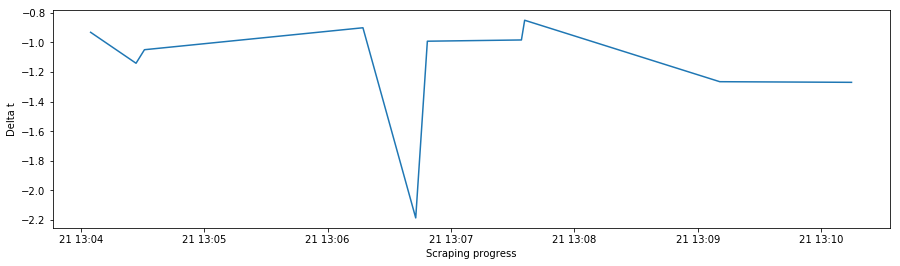

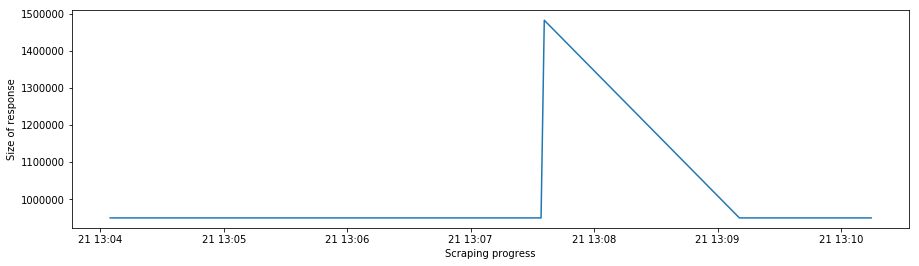

In [35]:
import datetime
log_df = pd.read_csv('my_log.csv',sep=';') # loading the log, separated by ";"
log_df = log_df[0:10].copy()
display(log_df)
#dt = log_df.dt.values[0] # get datetime values

log_df['dt'] = log_df.t.apply(datetime.datetime.fromtimestamp)
log_df['dt'] = pd.to_datetime(log_df.t,unit='s') # Convert the time column 't' to datetime 

plt.figure(figsize=(15,4))
plt.plot(log_df.dt,log_df.delta_t)
plt.ylabel('Delta t')
plt.xlabel('Scraping progress')
plt.savefig('LogGraphTime.png')

# Plot the response size over time.
plt.figure(figsize=(15,4))
plt.ylabel('Size of response')
plt.xlabel('Scraping progress')
plt.plot(log_df.dt,log_df.response_size)

## Investigate errors
log_df.success.value_counts() ## Count errors
## Groupby time
# round the time for aggregation
log_df['dt_minute'] = log_df.dt.apply(lambda x: x-datetime.timedelta(seconds=x.second,microseconds=x.microsecond))
#log_df['dt_hour'] = log_df.dt.apply(lambda x: x-datetime.timedelta(minutes=x.minute,seconds=x.second,microseconds=x.microsecond))
#log_df.groupby('dt_hour').success.mean()
plt.savefig('LogGraph.png')

THE END